In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# (라이브러리 설치가 필요할 수 있습니다)
# !pip install yellowbrick

print("--- [분석 3] 1단계: 데이터 통합 (e + a + d) ---")

# --- 1. ★ 파일 경로를 정확히 지정해주세요 ★ ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/" # (이전 경로)

# --- 2. 파일명 변수 (업로드된 5개 파일) ---
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

# --- 3. 컬럼명 리스트 정의 ---
e_cols = [f'e{i}' for i in range(1, 257)]  # 줄거리 벡터 (256개)
a_cols = [f'a{i}'for i in range(1, 19)]   # 배우 벡터 (18개)
d_cols = [f'd{i}'for i in range(1, 19)]   # 감독 벡터 (18개)
feature_cols = e_cols + a_cols + d_cols   # 총 292개 피처

# --- 4. 데이터 로드 ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)

    print("5개 CSV 파일 로드 성공.")

    # --- 5. 'e' 벡터(줄거리) 통합 ---
    all_movies_e = pd.concat([
        train_df[['Movie_Title'] + e_cols],
        test_df[['Movie_Title'] + e_cols],
        predict_df[['Movie_Title'] + e_cols]
    ], ignore_index=True)
    all_movies_e = all_movies_e.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

    # --- 6. 'a' 벡터(배우) 및 'd' 벡터(감독) 결합 ---
    merged_df = pd.merge(all_movies_e, actor_df, on="Movie_Title", how="left")
    merged_df = pd.merge(merged_df, director_df, on="Movie_Title", how="left")

    # --- 7. 클러스터링용 최종 데이터 생성 ---
    analysis_df = merged_df.dropna(subset=feature_cols).reset_index(drop=True)

    # (해석을 위해 영화 제목은 따로 보관)
    movie_titles_df = analysis_df[['Movie_Title']]
    # (수학 연산에 사용할 292개 피처만 분리)
    features_for_scaling = analysis_df[feature_cols]

    print(f"\n데이터 통합 완료.")
    print(f"분석 대상 영화: {len(analysis_df)}편")
    print(f"사용 피처 개수: {len(feature_cols)}개 (e:256 + a:18 + d:18)")
    print("'features_for_scaling' 변수가 생성되었습니다.")

except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"경로를 확인해주세요: {path_prefix}")
    print("파일을 찾을 수 없습니다. path_prefix 변수의 경로를 수정해주세요.")
except Exception as e:
    print(f"알 수 없는 오류 발생: {e}")

--- [분석 3] 1단계: 데이터 통합 (e + a + d) ---
5개 CSV 파일 로드 성공.

데이터 통합 완료.
분석 대상 영화: 2146편
사용 피처 개수: 292개 (e:256 + a:18 + d:18)
'features_for_scaling' 변수가 생성되었습니다.


In [19]:
from sklearn.preprocessing import StandardScaler

print("\n--- [분석 3] 2단계: 데이터 정규화 (스케일링) ---")

# (1단계에서 'features_for_scaling'이 생성되어 있어야 함)
if 'features_for_scaling' not in locals():
    print("오류: 1단계에서 'features_for_scaling' 변수가 생성되지 않았습니다.")
    print("1단계 코드를 먼저 실행해주세요.")
else:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_for_scaling)

    print(f"스케일링 완료. (Shape: {scaled_features.shape})")
    print("'scaled_features' 변수에 292개 피처의 스케일링된 값이 저장되었습니다.")


--- [분석 3] 2단계: 데이터 정규화 (스케일링) ---
스케일링 완료. (Shape: (2146, 292))
'scaled_features' 변수에 292개 피처의 스케일링된 값이 저장되었습니다.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 3-A] 1단계: '핵심 줄거리' 16개 추출 ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

e_cols = [f'e{i}' for i in range(1, 257)]  # 원본 줄거리 (256개)
a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)

# --- 2. 데이터 로드 (e, a, d) ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("5개 CSV 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")
    # (파일을 못찾으면 여기서 중단됩니다)

# --- 3. 'e' 벡터(줄거리) 통합 ---
all_movies_e = pd.concat([
    train_df[['Movie_Title'] + e_cols],
    test_df[['Movie_Title'] + e_cols],
    predict_df[['Movie_Title'] + e_cols]
], ignore_index=True)
all_movies_e = all_movies_e.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

# --- 4. 'e' 벡터만 스케일링 및 PCA ---
e_features = all_movies_e[e_cols]
scaler_e = StandardScaler()
e_scaled = scaler_e.fit_transform(e_features)

pca_e = PCA(n_components=16, random_state=42) # ★ 중요도 Top 16개만 추출
e_pca_16 = pca_e.fit_transform(e_scaled)

print(f"\n'e' 벡터(256개) -> 'e_pca_16' (16개)로 압축 완료.")
print(f"설명된 총 분산 (Top 16): {np.sum(pca_e.explained_variance_ratio_)*100:.2f}%")

# --- 5. e_pca_16을 DataFrame으로 변환 ---
e_pca_16_cols = [f'e_pc{i}' for i in range(1, 17)]
e_pca_16_df = pd.DataFrame(e_pca_16, columns=e_pca_16_cols)
e_pca_16_df['Movie_Title'] = all_movies_e['Movie_Title']

--- [분석 3-A] 1단계: '핵심 줄거리' 16개 추출 ---
5개 CSV 파일 로드 성공.

'e' 벡터(256개) -> 'e_pca_16' (16개)로 압축 완료.
설명된 총 분산 (Top 16): 40.38%


In [21]:
print("\n--- [분석 3-A] 2단계: 데이터 통합 (e_pca_16 + a + d) ---")

# (e_pca_16) + (a)
merged_df = pd.merge(e_pca_16_df, actor_df, on="Movie_Title", how="left")
# (e_pca_16 + a) + (d)
merged_df = pd.merge(merged_df, director_df, on="Movie_Title", how="left")

# --- 2. 클러스터링용 최종 데이터 생성 ---
# (a 또는 d 벡터가 없는 영화는 분석에서 제외)
feature_cols_16 = e_pca_16_cols + a_cols + d_cols # (16 + 18 + 18 = 52개 피처)
analysis_df_16 = merged_df.dropna(subset=feature_cols_16).reset_index(drop=True)

# (해석을 위해 영화 제목은 따로 보관)
movie_titles_df_16 = analysis_df_16[['Movie_Title']]
# (수학 연산에 사용할 52개 피처만 분리)
features_for_scaling_16 = analysis_df_16[feature_cols_16]

print(f"데이터 통합 완료 (Top 16).")
print(f"분석 대상 영화: {len(analysis_df_16)}편")
print(f"사용 피처 개수: {len(feature_cols_16)}개 (e_pca:16 + a:18 + d:18)")


--- [분석 3-A] 2단계: 데이터 통합 (e_pca_16 + a + d) ---
데이터 통합 완료 (Top 16).
분석 대상 영화: 2146편
사용 피처 개수: 52개 (e_pca:16 + a:18 + d:18)


In [22]:
print("\n--- [분석 3-A] 3단계: 데이터 정규화 (스케일링) ---")

scaler_16 = StandardScaler()
scaled_features_16 = scaler_16.fit_transform(features_for_scaling_16)

print(f"스케일링 완료 (Top 16). (Shape: {scaled_features_16.shape})")


--- [분석 3-A] 3단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (Top 16). (Shape: (2146, 52))



--- [분석 3-A] 4단계: 최적의 K 찾기 (Top 16) ---
K-Elbow 피팅을 시작합니다... (Top 16)


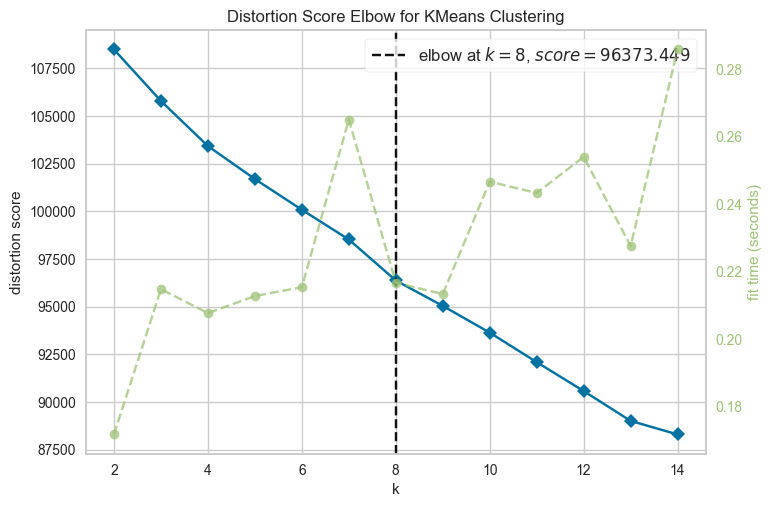

Yellowbrick 추천 K값 (Top 16): 8


In [23]:
print("\n--- [분석 3-A] 4단계: 최적의 K 찾기 (Top 16) ---")

model_16 = KMeans(n_init=10, random_state=42)
visualizer_16 = KElbowVisualizer(model_16, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (Top 16)")
visualizer_16.fit(scaled_features_16)
visualizer_16.show()

k_optimal_16 = visualizer_16.elbow_value_
print(f"Yellowbrick 추천 K값 (Top 16): {k_optimal_16}")

In [24]:
print(f"\n--- [분석 3-A] 5단계: 최종 클러스터링 (K={k_optimal_16}) 해석 ---")

# 1. 최종 K-Means 모델 실행
kmeans_16 = KMeans(n_clusters=k_optimal_16, n_init=10, random_state=42)
clusters_16 = kmeans_16.fit_predict(scaled_features_16)

# 2. 원본 analysis_df_16에 'new_genre' 클러스터 라벨 추가
analysis_df_16['new_genre'] = clusters_16

# 3. 각 "새로운 장르"의 특징 분석 (a, d 벡터 평균값)
cluster_means_16 = analysis_df_16.groupby('new_genre')[a_cols + d_cols].mean()

print(f"\n--- [결과: Top 16] {k_optimal_16}개의 '새로운 장르' 특징 ---")
pd.set_option('display.precision', 3)
print(cluster_means_16)

# 4. 각 "새로운 장르"의 영화 제목 샘플 확인 (줄거리 유추용)
print(f"\n--- [참고: Top 16] 영화 샘플 (각 5편) ---")
for i in range(k_optimal_16):
    print(f"\n=== New Genre Cluster {i} ===")
    sample_movies = analysis_df_16[analysis_df_16['new_genre'] == i]['Movie_Title'].sample(5, random_state=42, replace=True)
    for movie in sample_movies:
        print(f"  - {movie}")


--- [분석 3-A] 5단계: 최종 클러스터링 (K=8) 해석 ---

--- [결과: Top 16] 8개의 '새로운 장르' 특징 ---
              a1     a2     a3     a4     a5     a6     a7     a8     a9  \
new_genre                                                                  
0          0.342  0.080  0.012  0.003  0.043  0.102  0.054  0.106  0.068   
1          0.347  0.057  0.020  0.014  0.040  0.097  0.047  0.128  0.058   
2          0.302  0.075  0.014  0.004  0.039  0.102  0.054  0.091  0.086   
3          0.065  0.012  0.787  0.062  0.004  0.014  0.004  0.015  0.010   
4          0.453  0.105  0.012  0.002  0.018  0.072  0.019  0.126  0.045   
5          0.328  0.080  0.021  0.003  0.042  0.104  0.057  0.100  0.069   
6          0.306  0.073  0.015  0.007  0.029  0.110  0.110  0.087  0.072   
7          0.177  0.033  0.009  0.001  0.069  0.153  0.089  0.058  0.144   

             a10  ...     d9        d10    d11        d12    d13        d14  \
new_genre         ...                                                         
0 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 3-B] 1단계: '핵심 줄거리' 32개 추출 ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

e_cols = [f'e{i}' for i in range(1, 257)]  # 원본 줄거리 (256개)
a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)

# --- 2. 데이터 로드 (e, a, d) ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("5개 CSV 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")

# --- 3. 'e' 벡터(줄거리) 통합 ---
all_movies_e = pd.concat([
    train_df[['Movie_Title'] + e_cols],
    test_df[['Movie_Title'] + e_cols],
    predict_df[['Movie_Title'] + e_cols]
], ignore_index=True)
all_movies_e = all_movies_e.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

# --- 4. 'e' 벡터만 스케일링 및 PCA ---
e_features = all_movies_e[e_cols]
scaler_e = StandardScaler()
e_scaled = scaler_e.fit_transform(e_features)

pca_e_32 = PCA(n_components=32, random_state=42) # ★ 중요도 Top 32개만 추출
e_pca_32 = pca_e_32.fit_transform(e_scaled)

print(f"\n'e' 벡터(256개) -> 'e_pca_32' (32개)로 압축 완료.")
print(f"설명된 총 분산 (Top 32): {np.sum(pca_e_32.explained_variance_ratio_)*100:.2f}%")

# --- 5. e_pca_32를 DataFrame으로 변환 ---
e_pca_32_cols = [f'e_pc{i}' for i in range(1, 33)]
e_pca_32_df = pd.DataFrame(e_pca_32, columns=e_pca_32_cols)
e_pca_32_df['Movie_Title'] = all_movies_e['Movie_Title']

--- [분석 3-B] 1단계: '핵심 줄거리' 32개 추출 ---
5개 CSV 파일 로드 성공.

'e' 벡터(256개) -> 'e_pca_32' (32개)로 압축 완료.
설명된 총 분산 (Top 32): 53.76%


In [26]:
print("\n--- [분석 3-B] 2단계: 데이터 통합 (e_pca_32 + a + d) ---")

# (e_pca_32) + (a)
merged_df_32 = pd.merge(e_pca_32_df, actor_df, on="Movie_Title", how="left")
# (e_pca_32 + a) + (d)
merged_df_32 = pd.merge(merged_df_32, director_df, on="Movie_Title", how="left")

# --- 2. 클러스터링용 최종 데이터 생성 ---
feature_cols_32 = e_pca_32_cols + a_cols + d_cols # (32 + 18 + 18 = 68개 피처)
analysis_df_32 = merged_df_32.dropna(subset=feature_cols_32).reset_index(drop=True)

# (해석을 위해 영화 제목은 따로 보관)
movie_titles_df_32 = analysis_df_32[['Movie_Title']]
# (수학 연산에 사용할 68개 피처만 분리)
features_for_scaling_32 = analysis_df_32[feature_cols_32]

print(f"데이터 통합 완료 (Top 32).")
print(f"분석 대상 영화: {len(analysis_df_32)}편")
print(f"사용 피처 개수: {len(feature_cols_32)}개 (e_pca:32 + a:18 + d:18)")


--- [분석 3-B] 2단계: 데이터 통합 (e_pca_32 + a + d) ---
데이터 통합 완료 (Top 32).
분석 대상 영화: 2146편
사용 피처 개수: 68개 (e_pca:32 + a:18 + d:18)


In [27]:
print("\n--- [분석 3-B] 3단계: 데이터 정규화 (스케일링) ---")

scaler_32 = StandardScaler()
scaled_features_32 = scaler_32.fit_transform(features_for_scaling_32)

print(f"스케일링 완료 (Top 32). (Shape: {scaled_features_32.shape})")


--- [분석 3-B] 3단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (Top 32). (Shape: (2146, 68))



--- [분석 3-B] 4단계: 최적의 K 찾기 (Top 32) ---
K-Elbow 피팅을 시작합니다... (Top 32)


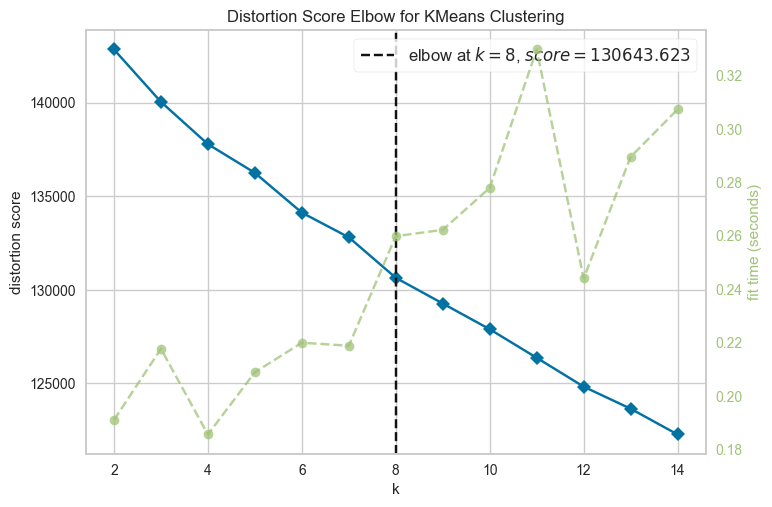

Yellowbrick 추천 K값 (Top 32): 8


In [28]:
print("\n--- [분석 3-B] 4단계: 최적의 K 찾기 (Top 32) ---")

model_32 = KMeans(n_init=10, random_state=42)
visualizer_32 = KElbowVisualizer(model_32, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (Top 32)")
visualizer_32.fit(scaled_features_32)
visualizer_32.show()

k_optimal_32 = visualizer_32.elbow_value_
print(f"Yellowbrick 추천 K값 (Top 32): {k_optimal_32}")

In [29]:
print(f"\n--- [분석 3-B] 5단계: 최종 클러스터링 (K={k_optimal_32}) 해석 ---")

# 1. 최종 K-Means 모델 실행
kmeans_32 = KMeans(n_clusters=k_optimal_32, n_init=10, random_state=42)
clusters_32 = kmeans_32.fit_predict(scaled_features_32)

# 2. 원본 analysis_df_32에 'new_genre' 클러스터 라벨 추가
analysis_df_32['new_genre'] = clusters_32

# 3. 각 "새로운 장르"의 특징 분석 (a, d 벡터 평균값)
cluster_means_32 = analysis_df_32.groupby('new_genre')[a_cols + d_cols].mean()

print(f"\n--- [결과: Top 32] {k_optimal_32}개의 '새로운 장르' 특징 ---")
pd.set_option('display.precision', 3)
print(cluster_means_32)

# 4. 각 "새로운 장르"의 영화 제목 샘플 확인 (줄거리 유추용)
print(f"\n--- [참고: Top 32] 영화 샘플 (각 5편) ---")
for i in range(k_optimal_32):
    print(f"\n=== New Genre Cluster {i} ===")
    sample_movies = analysis_df_32[analysis_df_32['new_genre'] == i]['Movie_Title'].sample(5, random_state=42, replace=True)
    for movie in sample_movies:
        print(f"  - {movie}")


--- [분석 3-B] 5단계: 최종 클러스터링 (K=8) 해석 ---

--- [결과: Top 32] 8개의 '새로운 장르' 특징 ---
              a1     a2     a3     a4     a5     a6     a7     a8     a9  \
new_genre                                                                  
0          0.077  0.038  0.003  0.006  0.011  0.043  0.593  0.044  0.013   
1          0.324  0.084  0.023  0.015  0.039  0.104  0.038  0.107  0.066   
2          0.318  0.076  0.012  0.006  0.048  0.099  0.031  0.097  0.096   
3          0.456  0.107  0.013  0.001  0.019  0.067  0.019  0.133  0.040   
4          0.341  0.075  0.017  0.004  0.031  0.119  0.028  0.097  0.079   
5          0.207  0.033  0.008  0.009  0.070  0.169  0.029  0.056  0.156   
6          0.079  0.013  0.821  0.012  0.004  0.013  0.005  0.013  0.012   
7          0.354  0.081  0.011  0.004  0.046  0.106  0.026  0.107  0.069   

             a10  ...     d9        d10    d11        d12    d13    d14  \
new_genre         ...                                                     
0         


--- [분석 3-C] 3단계: 차원 축소 (전체 PCA) ---
PCA 차원 축소 완료.
  -> 원본 피처 개수: 292개
  -> 축소된 피처 개수: 194개


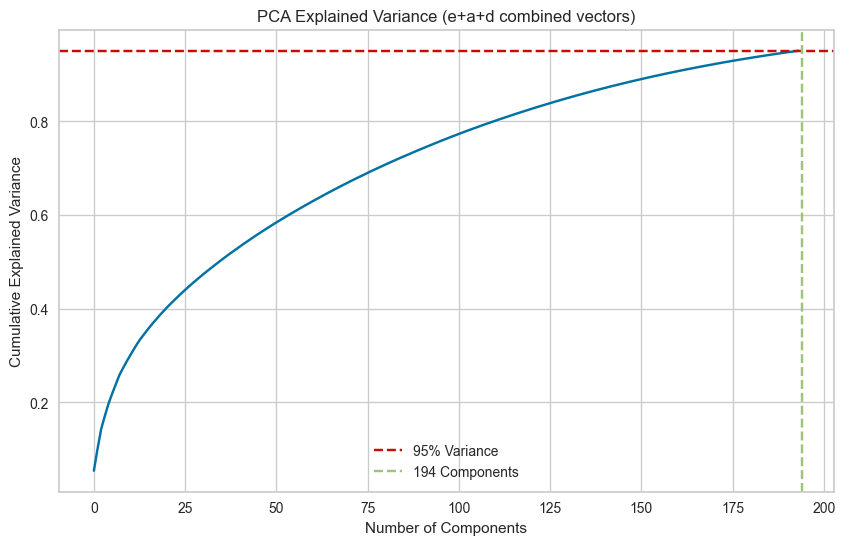

'pca_features_full' 변수에 압축된 피처가 저장되었습니다.


In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print("\n--- [분석 3-C] 3단계: 차원 축소 (전체 PCA) ---")
# (1, 2단계에서 'scaled_features'가 생성되어 있어야 함)

if 'scaled_features' not in locals():
    print("오류: 1, 2단계에서 'scaled_features' 변수가 생성되지 않았습니다.")
    print("1, 2단계 코드를 먼저 실행해주세요.")
else:
    # 1. PCA 실행 (원본 분산의 95% 유지)
    # (e+a+d 292개 피처 전체를 PCA)
    pca_full = PCA(n_components=0.95, random_state=42)
    pca_features_full = pca_full.fit_transform(scaled_features)

    print(f"PCA 차원 축소 완료.")
    print(f"  -> 원본 피처 개수: {scaled_features.shape[1]}개")
    print(f"  -> 축소된 피처 개수: {pca_full.n_components_}개")

    # 2. 설명된 분산 시각화 (확인용)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance (e+a+d combined vectors)')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    plt.axvline(x=pca_full.n_components_, color='g', linestyle='--', label=f'{pca_full.n_components_} Components')
    plt.legend()
    plt.show()

    print("'pca_features_full' 변수에 압축된 피처가 저장되었습니다.")

# 여기부터 =============

#### "새로운 장르" (배우 + 감독)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 4] 1단계: 데이터 통합 (a + d) ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)
feature_cols_ad = a_cols + d_cols          # 총 36개 피처

# --- 2. 데이터 로드 ---
try:
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("배우(a), 감독(d) 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")
    # (파일을 못찾으면 여기서 중단됩니다)

# --- 3. (a) + (d) 벡터 결합 ---
merged_df_ad = pd.merge(actor_df, director_df, on="Movie_Title", how="inner")

# --- 4. 클러스터링용 최종 데이터 생성 ---
# (dropna는 필요 없음, inner join으로 a, d 모두 있는 영화만 남음)
analysis_df_ad = merged_df_ad.copy()

# (해석을 위해 영화 제목은 따로 보관)
movie_titles_df_ad = analysis_df_ad[['Movie_Title']]
# (수학 연산에 사용할 36개 피처만 분리)
features_for_scaling_ad = analysis_df_ad[feature_cols_ad]

print(f"\n데이터 통합 완료 (a + d).")
print(f"분석 대상 영화: {len(analysis_df_ad)}편")
print(f"사용 피처 개수: {len(feature_cols_ad)}개 (a:18 + d:18)")

--- [분석 4] 1단계: 데이터 통합 (a + d) ---
배우(a), 감독(d) 파일 로드 성공.

데이터 통합 완료 (a + d).
분석 대상 영화: 130449편
사용 피처 개수: 36개 (a:18 + d:18)


In [32]:
print("\n--- [분석 4] 2단계: 데이터 정규화 (스케일링) ---")

scaler_ad = StandardScaler()
scaled_features_ad = scaler_ad.fit_transform(features_for_scaling_ad)

print(f"스케일링 완료 (a + d). (Shape: {scaled_features_ad.shape})")


--- [분석 4] 2단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (a + d). (Shape: (130449, 36))



--- [분석 4] 3단계: 최적의 K 찾기 (a + d) ---
K-Elbow 피팅을 시작합니다... (a + d)


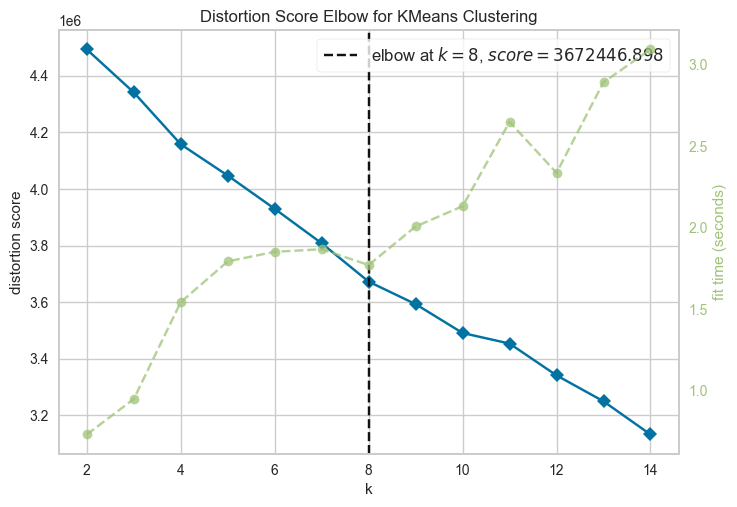

Yellowbrick 추천 K값 (a + d): 8


In [33]:
print("\n--- [분석 4] 3단계: 최적의 K 찾기 (a + d) ---")

model_ad = KMeans(n_init=10, random_state=42)
visualizer_ad = KElbowVisualizer(model_ad, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (a + d)")
visualizer_ad.fit(scaled_features_ad)
visualizer_ad.show()

k_optimal_ad = visualizer_ad.elbow_value_
print(f"Yellowbrick 추천 K값 (a + d): {k_optimal_ad}")

In [34]:
print(f"\n--- [분석 4] 4단계: 최종 클러스터링 (K={k_optimal_ad}) 해석 ---")

# 1. 최종 K-Means 모델 실행
kmeans_ad = KMeans(n_clusters=k_optimal_ad, n_init=10, random_state=42)
clusters_ad = kmeans_ad.fit_predict(scaled_features_ad)

# 2. 원본 analysis_df_ad에 'new_genre' 클러스터 라벨 추가
analysis_df_ad['new_genre'] = clusters_ad

# 3. 각 "새로운 장르"의 특징 분석 (a, d 벡터 평균값)
cluster_means_ad = analysis_df_ad.groupby('new_genre')[a_cols + d_cols].mean()

print(f"\n--- [결과: a + d] {k_optimal_ad}개의 '새로운 장르' 특징 ---")
pd.set_option('display.precision', 3)
print(cluster_means_ad)

# 4. 각 "새로운 장르"의 영화 제목 샘플 확인 (줄거리 유추용)
print(f"\n--- [참고: a + d] 영화 샘플 (각 5편) ---")
for i in range(k_optimal_ad):
    print(f"\n=== New Genre Cluster {i} ===")
    sample_movies = analysis_df_ad[analysis_df_ad['new_genre'] == i]['Movie_Title'].sample(5, random_state=42, replace=True)
    for movie in sample_movies:
        print(f"  - {movie}")


--- [분석 4] 4단계: 최종 클러스터링 (K=8) 해석 ---

--- [결과: a + d] 8개의 '새로운 장르' 특징 ---
              a1         a2     a3         a4     a5     a6         a7  \
new_genre                                                                
0          0.355  9.892e-02  0.013  9.757e-04  0.019  0.107  2.144e-02   
1          0.072  1.524e-02  0.007  1.065e-03  0.005  0.072  4.861e-01   
2          0.067  2.231e-02  0.821  1.117e-05  0.005  0.007  5.470e-03   
3          0.358  1.001e-01  0.013  9.695e-04  0.018  0.106  2.118e-02   
4          0.343  9.573e-02  0.016  9.685e-04  0.026  0.104  2.631e-02   
5          0.314  8.679e-02  0.048  9.120e-04  0.038  0.097  4.128e-02   
6          0.021  1.422e-04  0.005  4.712e-01  0.003  0.012  9.987e-05   
7          0.131  2.902e-02  0.002  5.568e-04  0.300  0.051  1.146e-02   

                  a8     a9        a10  ...     d9    d10    d11    d12  \
new_genre                               ...                               
0          1.230e-01  0.071  2.07

## --- [분석 4] "새로운 장르" 최종 분석 (K=8) ---

**[분석 개요]**
줄거리(`e`) 벡터를 제외하고, 오직 **배우(`a`)**와 **감독(`d`)**의 DNA만으로 영화들을 8개 그룹으로 분류한 결과입니다.

---

### 1. "배우 DNA" 중심의 특수 장르 (4개)

배우의 전문성(`a` 벡터)이 압도적으로 높아, **"출연 배우"**에 의해 장르가 정의되는 그룹입니다.

| 새로운 장르 (Cluster) | 핵심 DNA (가장 높은 값) | 해석: "줄글로 설명 가능한 새로운 장르" |
| :--- | :--- | :--- |
| **Cluster 2** | `a3 (다큐멘터리) = 82.1%` | **"다큐멘터리 전문 배우/내레이터 그룹"**<br/>(영화의 본질이 '다큐멘터리' 그 자체인, 가장 순도 높은 그룹) |
| **Cluster 1** | `a7 (애니메이션) = 48.6%` | **"애니메이션 전문 성우 그룹"**<br/>(전문 성우진이 참여한 '애니메이션' 영화로 강력하게 묶인 그룹) |
| **Cluster 6** | `a4 (공연) = 47.1%` | **"공연/뮤지컬 전문 배우 그룹"**<br/>(아이돌, 뮤지컬 배우 등 '공연' 기반 배우들이 출연하는 영화 그룹) |
| **Cluster 7** | `a5 (공포) = 30.0%`<br/>`a9 (스릴러) = 24.0%` | **"공포 & 스릴러 전문 배우 그룹"**<br/>('공포'와 '스릴러' 장르에 특화된 배우들이 주연인 영화 그룹) |

---

### 2. "감독 DNA" 중심의 장르 (1개)

배우보다는 감독의 전문성(`d` 벡터)이 돋보여, **"감독"**에 의해 장르가 정의되는 그룹입니다.

| 새로운 장르 (Cluster) | 핵심 DNA (가장 높은 값) | 해석: "줄글로 설명 가능한 새로운 장르" |
| :--- | :--- | :--- |
| **Cluster 4** | `d12 (어드벤처) = 10.5%` | **"어드벤처 전문 감독 그룹"**<br/>(배우의 장르보다 '어드벤처' 전문 감독의 성향이 강하게 드러나는 영화 그룹) |

---

### 3. "주류/혼합" 장르 (3개)

`a1(드라마)` 비중이 전반적으로 높게 깔려있으며, 여러 장르가 혼합된 **"가장 일반적인 상업 영화"** 그룹입니다.

| 새로운 장르 (Cluster) | 핵심 DNA (가장 높은 값) | 해석: "줄글로 설명 가능한 새로운 장르" |
| :--- | :--- | :--- |
| **Cluster 0** | `a1 (드라마) = 35.5%`<br/>`d9 (스릴러) = 18.3%` | **"드라마 기반 & 스릴러 감독 그룹"**<br/>(드라마 전문 배우가 출연하되, '스릴러' 전문 감독이 연출한 영화) |
| **Cluster 3** | `a1 (드라마) = 35.8%` | **"주류 드라마 (유형 A)"**<br/>(가장 보편적인 '드라마' 전문 배우/감독 조합의 영화) |
| **Cluster 5** | `a1 (드라마) = 31.4%` | **"주류 드라마 (유형 B)"**<br/>(유형 A와 유사하지만, a3(다큐) 등 다른 성향이 미세하게 혼합된 그룹) |

# ---임베딩 16

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 5] 1단계: 데이터 통합 (e1~e16 + a + d) ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

# ★ 핵심: e1~e16 (16개)만 사용
e_cols_16 = [f'e{i}' for i in range(1, 17)] 
a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)
feature_cols_e16 = e_cols_16 + a_cols + d_cols # 총 52개 피처

# --- 2. 데이터 로드 (e, a, d) ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("5개 CSV 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")
    # (파일을 못찾으면 여기서 중단됩니다)

# --- 3. 'e1~e16' 벡터(줄거리) 통합 ---
all_movies_e16 = pd.concat([
    train_df[['Movie_Title'] + e_cols_16],
    test_df[['Movie_Title'] + e_cols_16],
    predict_df[['Movie_Title'] + e_cols_16]
], ignore_index=True)
all_movies_e16 = all_movies_e16.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

# --- 4. (e1~e16) + (a) + (d) 벡터 결합 ---
merged_df_e16 = pd.merge(all_movies_e16, actor_df, on="Movie_Title", how="left")
merged_df_e16 = pd.merge(merged_df_e16, director_df, on="Movie_Title", how="left")

# --- 5. 클러스터링용 최종 데이터 생성 ---
analysis_df_e16 = merged_df_e16.dropna(subset=feature_cols_e16).reset_index(drop=True)

# (해석을 위해 영화 제목은 따로 보관)
movie_titles_df_e16 = analysis_df_e16[['Movie_Title']]
# (수학 연산에 사용할 52개 피처만 분리)
features_for_scaling_e16 = analysis_df_e16[feature_cols_e16]

print(f"\n데이터 통합 완료 (e1~e16 + a + d).")
print(f"분석 대상 영화: {len(analysis_df_e16)}편")
print(f"사용 피처 개수: {len(feature_cols_e16)}개 (e:16 + a:18 + d:18)")

--- [분석 5] 1단계: 데이터 통합 (e1~e16 + a + d) ---
5개 CSV 파일 로드 성공.

데이터 통합 완료 (e1~e16 + a + d).
분석 대상 영화: 2146편
사용 피처 개수: 52개 (e:16 + a:18 + d:18)


In [42]:
print("\n--- [분석 5] 2단계: 데이터 정규화 (스케일링) ---")

scaler_e16 = StandardScaler()
scaled_features_e16 = scaler_e16.fit_transform(features_for_scaling_e16)

print(f"스케일링 완료 (e1~e16 + a + d). (Shape: {scaled_features_e16.shape})")


--- [분석 5] 2단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (e1~e16 + a + d). (Shape: (2146, 52))



--- [분석 5] 3단계: 최적의 K 찾기 (e1~e16 + a + d) ---
K-Elbow 피팅을 시작합니다... (e1~e16 + a + d)


c:\Users\yusse\AppData\Local\Programs\Python\Python313\Lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\yusse\AppData\Local\Programs\Python\Python313\Lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


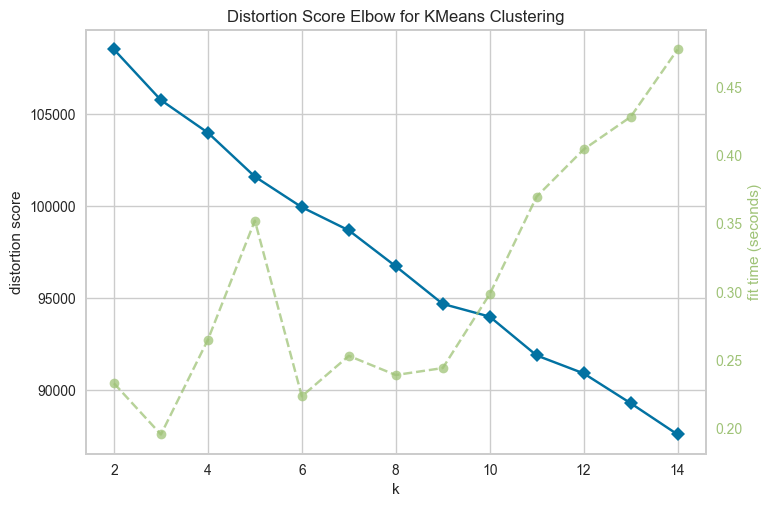

Yellowbrick 추천 K값 (e1~e16 + a + d): None


In [44]:
print("\n--- [분석 5] 3단계: 최적의 K 찾기 (e1~e16 + a + d) ---")

model_e16 = KMeans(n_init=10, random_state=42)
visualizer_e16 = KElbowVisualizer(model_e16, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (e1~e16 + a + d)")
visualizer_e16.fit(scaled_features_e16)
visualizer_e16.show()

k_optimal_e16 = visualizer_e16.elbow_value_
print(f"Yellowbrick 추천 K값 (e1~e16 + a + d): {k_optimal_e16}")

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 6] 1단계: 데이터 통합 (e1~e32 + a + d) ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

# ★ 핵심: e1~e32 (32개)만 사용
e_cols_32 = [f'e{i}' for i in range(1, 33)] 
a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)
feature_cols_e32 = e_cols_32 + a_cols + d_cols # 총 68개 피처

# --- 2. 데이터 로드 (e, a, d) ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("5개 CSV 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")

# --- 3. 'e1~e32' 벡터(줄거리) 통합 ---
all_movies_e32 = pd.concat([
    train_df[['Movie_Title'] + e_cols_32],
    test_df[['Movie_Title'] + e_cols_32],
    predict_df[['Movie_Title'] + e_cols_32]
], ignore_index=True)
all_movies_e32 = all_movies_e32.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

# --- 4. (e1~e32) + (a) + (d) 벡터 결합 ---
merged_df_e32 = pd.merge(all_movies_e32, actor_df, on="Movie_Title", how="left")
merged_df_e32 = pd.merge(merged_df_e32, director_df, on="Movie_Title", how="left")

# --- 5. 클러스터링용 최종 데이터 생성 ---
analysis_df_e32 = merged_df_e32.dropna(subset=feature_cols_e32).reset_index(drop=True)
features_for_scaling_e32 = analysis_df_e32[feature_cols_e32]

print(f"\n데이터 통합 완료 (e1~e32 + a + d).")
print(f"분석 대상 영화: {len(analysis_df_e32)}편")
print(f"사용 피처 개수: {len(feature_cols_e32)}개 (e:32 + a:18 + d:18)")

--- [분석 6] 1단계: 데이터 통합 (e1~e32 + a + d) ---
5개 CSV 파일 로드 성공.

데이터 통합 완료 (e1~e32 + a + d).
분석 대상 영화: 2146편
사용 피처 개수: 68개 (e:32 + a:18 + d:18)


In [47]:
print("\n--- [분석 6] 2단계: 데이터 정규화 (스케일링) ---")

scaler_e32 = StandardScaler()
scaled_features_e32 = scaler_e32.fit_transform(features_for_scaling_e32)

print(f"스케일링 완료 (e1~e32 + a + d). (Shape: {scaled_features_e32.shape})")


--- [분석 6] 2단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (e1~e32 + a + d). (Shape: (2146, 68))



--- [분석 6] 3 & 4단계: K 찾기 및 최종 클러스터링 ---

--- [분석 6] 3단계: 최적의 K 찾기 (e1~e32 + a + d) ---
K-Elbow 피팅을 시작합니다... (e1~e32 + a + d)


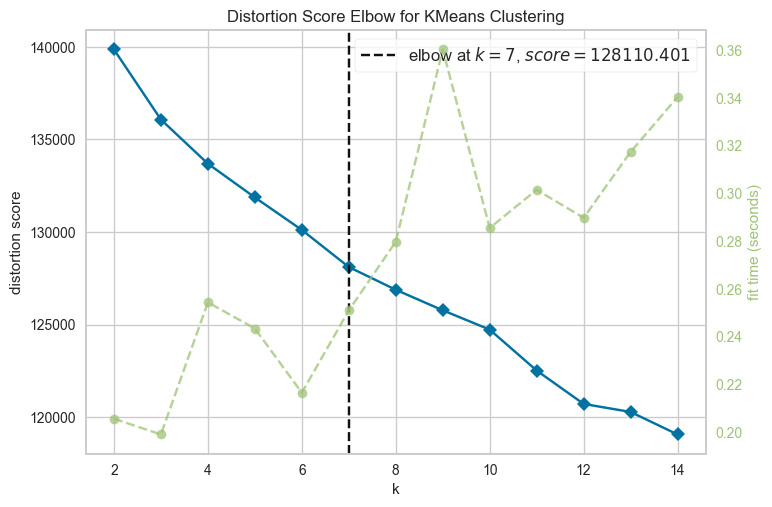

Yellowbrick 추천 K값 (e1~e32 + a + d): 7

--- [분석 6] 4단계: 최종 클러스터링 (K=7) 해석 ---

--- [결과: e1~e32 + a + d] 7개의 '새로운 장르' 특징 ---
              a1     a2     a3     a4     a5     a6     a7     a8     a9  \
new_genre                                                                  
0          0.343  0.096  0.016  0.007  0.041  0.101  0.030  0.114  0.070   
1          0.331  0.073  0.017  0.003  0.041  0.104  0.057  0.101  0.079   
2          0.275  0.082  0.073  0.036  0.015  0.094  0.051  0.125  0.048   
3          0.336  0.077  0.014  0.006  0.038  0.100  0.061  0.095  0.081   
4          0.359  0.085  0.011  0.003  0.028  0.089  0.057  0.105  0.065   
5          0.308  0.062  0.010  0.008  0.045  0.122  0.060  0.089  0.089   
6          0.059  0.012  0.863  0.006  0.003  0.012  0.004  0.009  0.009   

             a10  ...     d9    d10    d11    d12    d13    d14    d15    d16  \
new_genre         ...                                                           
0          0.023  ...  0.073  

In [ ]:
print("\n--- [분석 6] 3 & 4단계: K 찾기 및 최종 클러스터링 ---")

# --- 3단계: 최적의 K 찾기 (Elbow Method) ---
print("\n--- [분석 6] 3단계: 최적의 K 찾기 (e1~e32 + a + d) ---")
model_e32 = KMeans(n_init=10, random_state=42)
visualizer_e32 = KElbowVisualizer(model_e32, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (e1~e32 + a + d)")
visualizer_e32.fit(scaled_features_e32)
visualizer_e32.show()

k_optimal_e32 = visualizer_e32.elbow_value_

if k_optimal_e32 is None:
    print("자동 K값 탐지 실패. Elbow 그래프를 보고 K값을 수동으로 입력해주세요.")
    # (★만약 K가 None으로 뜨면, 8, 9 등 그래프 보고 적절한 값으로 수정)
    k_optimal_e32 = 8 
    print(f"K값을 {k_optimal_e32}(으)로 수동 설정합니다.")
else:
    print(f"Yellowbrick 추천 K값 (e1~e32 + a + d): {k_optimal_e32}")

# --- 4단계: 최종 클러스터링 및 "새로운 장르" 해석 ---
print(f"\n--- [분석 6] 4단계: 최종 클러스터링 (K={k_optimal_e32}) 해석 ---")

# 1. 최종 K-Means 모델 실행
kmeans_e32 = KMeans(n_clusters=k_optimal_e32, n_init=10, random_state=42)
clusters_e32 = kmeans_e32.fit_predict(scaled_features_e32)

# 2. 원본 analysis_df_e32에 'new_genre' 클러스터 라벨 추가
analysis_df_e32['new_genre'] = clusters_e32

# 3. 각 "새로운 장르"의 특징 분석 (a, d 벡터 평균값)
cluster_means_e32 = analysis_df_e32.groupby('new_genre')[a_cols + d_cols].mean()

print(f"\n--- [결과: e1~e32 + a + d] {k_optimal_e32}개의 '새로운 장르' 특징 ---")
pd.set_option('display.precision', 3)
print(cluster_means_e32)

# 4. 각 "새로운 장르"의 영화 제목 샘플 확인 (줄거리 유추용)
print(f"\n--- [참고: e1~e32 + a + d] 영화 샘플 (각 5편) ---")
for i in range(k_optimal_e32):
    print(f"\n=== New Genre Cluster {i} ===")
    sample_movies = analysis_df_e32[analysis_df_e32['new_genre'] == i]['Movie_Title'].sample(min(5, len(analysis_df_e32[analysis_df_e32['new_genre'] == i])), random_state=42, replace=True)
    for movie in sample_movies:
        print(f"  - {movie}")

# ==== 64

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print("--- [분석 7] 1단계: 데이터 통합 (e1~e64 + a + d) ---")

# --- 1. 파일 경로 및 컬럼명 정의 ---
path_prefix = "C:/Users/yusse/OneDrive/바탕 화면/"
train_file = path_prefix + "model_train_data.csv"
test_file = path_prefix + "model_test_data.csv"
predict_file = path_prefix + "model_predict_data.csv"
actor_file = path_prefix + "actor_genre.csv"
director_file = path_prefix + "director_genre.csv"

# ★ 핵심: e1~e64 (64개)만 사용
e_cols_64 = [f'e{i}' for i in range(1, 65)] 
a_cols = [f'a{i}' for i in range(1, 19)]   # 배우 (18개)
d_cols = [f'd{i}' for i in range(1, 19)]   # 감독 (18개)
feature_cols_e64 = e_cols_64 + a_cols + d_cols # 총 100개 피처

# --- 2. 데이터 로드 (e, a, d) ---
try:
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    predict_df = pd.read_csv(predict_file)
    actor_df = pd.read_csv(actor_file)
    director_df = pd.read_csv(director_file)
    print("5개 CSV 파일 로드 성공.")
except FileNotFoundError:
    print(f"---!!! 오류 !!!---")
    print(f"파일 경로를 확인해주세요: {path_prefix}")

# --- 3. 'e1~e64' 벡터(줄거리) 통합 ---
all_movies_e64 = pd.concat([
    train_df[['Movie_Title'] + e_cols_64],
    test_df[['Movie_Title'] + e_cols_64],
    predict_df[['Movie_Title'] + e_cols_64]
], ignore_index=True)
all_movies_e64 = all_movies_e64.drop_duplicates(subset=['Movie_Title']).reset_index(drop=True)

# --- 4. (e1~e64) + (a) + (d) 벡터 결합 ---
merged_df_e64 = pd.merge(all_movies_e64, actor_df, on="Movie_Title", how="left")
merged_df_e64 = pd.merge(merged_df_e64, director_df, on="Movie_Title", how="left")

# --- 5. 클러스터링용 최종 데이터 생성 ---
analysis_df_e64 = merged_df_e64.dropna(subset=feature_cols_e64).reset_index(drop=True)
features_for_scaling_e64 = analysis_df_e64[feature_cols_e64]

print(f"\n데이터 통합 완료 (e1~e64 + a + d).")
print(f"분석 대상 영화: {len(analysis_df_e64)}편")
print(f"사용 피처 개수: {len(feature_cols_e64)}개 (e:64 + a:18 + d:18)")

--- [분석 7] 1단계: 데이터 통합 (e1~e64 + a + d) ---
5개 CSV 파일 로드 성공.

데이터 통합 완료 (e1~e64 + a + d).
분석 대상 영화: 2146편
사용 피처 개수: 100개 (e:64 + a:18 + d:18)


In [50]:
print("\n--- [분석 7] 2단계: 데이터 정규화 (스케일링) ---")

scaler_e64 = StandardScaler()
scaled_features_e64 = scaler_e64.fit_transform(features_for_scaling_e64)

print(f"스케일링 완료 (e1~e64 + a + d). (Shape: {scaled_features_e64.shape})")


--- [분석 7] 2단계: 데이터 정규화 (스케일링) ---
스케일링 완료 (e1~e64 + a + d). (Shape: (2146, 100))



--- [분석 7] 3 & 4단계: K 찾기 및 최종 클러스터링 ---

--- [분석 7] 3단계: 최적의 K 찾기 (e1~e64 + a + d) ---
K-Elbow 피팅을 시작합니다... (e1~e64 + a + d)


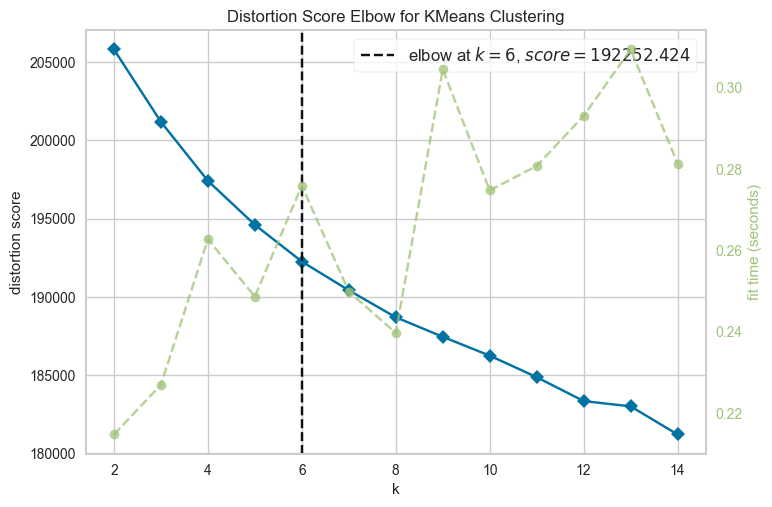

Yellowbrick 추천 K값 (e1~e64 + a + d): 6

--- [분석 7] 4단계: 최종 클러스터링 (K=6) 해석 ---

--- [결과: e1~e64 + a + d] 6개의 '새로운 장르' 특징 ---
              a1     a2     a3     a4     a5     a6     a7     a8     a9  \
new_genre                                                                  
0          0.334  0.077  0.042  0.006  0.032  0.098  0.053  0.098  0.070   
1          0.356  0.076  0.044  0.003  0.033  0.089  0.058  0.100  0.057   
2          0.284  0.061  0.053  0.008  0.041  0.114  0.058  0.085  0.090   
3          0.339  0.073  0.053  0.004  0.028  0.101  0.054  0.093  0.075   
4          0.291  0.070  0.039  0.006  0.052  0.101  0.060  0.096  0.092   
5          0.341  0.092  0.020  0.007  0.044  0.103  0.036  0.109  0.068   

             a10  ...     d9    d10    d11    d12    d13    d14    d15    d16  \
new_genre         ...                                                           
0          0.023  ...  0.065  0.020  0.034  0.022  0.032  0.019  0.008  0.018   
1          0.021  ...  0.

In [51]:
print("\n--- [분석 7] 3 & 4단계: K 찾기 및 최종 클러스터링 ---")

# --- 3단계: 최적의 K 찾기 (Elbow Method) ---
print("\n--- [분석 7] 3단계: 최적의 K 찾기 (e1~e64 + a + d) ---")
model_e64 = KMeans(n_init=10, random_state=42)
visualizer_e64 = KElbowVisualizer(model_e64, k=(2, 15)) # 2~14개 그룹 테스트

print("K-Elbow 피팅을 시작합니다... (e1~e64 + a + d)")
visualizer_e64.fit(scaled_features_e64)
visualizer_e64.show()

k_optimal_e64 = visualizer_e64.elbow_value_

if k_optimal_e64 is None:
    print("자동 K값 탐지 실패. Elbow 그래프를 보고 K값을 수동으로 입력해주세요.")
    # (★만약 K가 None으로 뜨면, 그래프 보고 적절한 값으로 수정)
    k_optimal_e64 = 8 
    print(f"K값을 {k_optimal_e64}(으)로 수동 설정합니다.")
else:
    print(f"Yellowbrick 추천 K값 (e1~e64 + a + d): {k_optimal_e64}")

# --- 4단계: 최종 클러스터링 및 "새로운 장르" 해석 ---
print(f"\n--- [분석 7] 4단계: 최종 클러스터링 (K={k_optimal_e64}) 해석 ---")

# 1. 최종 K-Means 모델 실행
kmeans_e64 = KMeans(n_clusters=k_optimal_e64, n_init=10, random_state=42)
clusters_e64 = kmeans_e64.fit_predict(scaled_features_e64)

# 2. 원본 analysis_df_e64에 'new_genre' 클러스터 라벨 추가
analysis_df_e64['new_genre'] = clusters_e64

# 3. 각 "새로운 장르"의 특징 분석 (a, d 벡터 평균값)
cluster_means_e64 = analysis_df_e64.groupby('new_genre')[a_cols + d_cols].mean()

print(f"\n--- [결과: e1~e64 + a + d] {k_optimal_e64}개의 '새로운 장르' 특징 ---")
pd.set_option('display.precision', 3)
print(cluster_means_e64)

# 4. 각 "새로운 장르"의 영화 제목 샘플 확인 (줄거리 유추용)
print(f"\n--- [참고: e1~e64 + a + d] 영화 샘플 (각 5편) ---")
for i in range(k_optimal_e64):
    print(f"\n=== New Genre Cluster {i} ===")
    sample_movies = analysis_df_e64[analysis_df_e64['new_genre'] == i]['Movie_Title'].sample(min(5, len(analysis_df_e64[analysis_df_e64['new_genre'] == i])), random_state=42, replace=True)
    for movie in sample_movies:
        print(f"  - {movie}")

## "새로운 장르" 분석 기반 마케팅 전략 

---

### 📈 전략 1: "제작진 DNA" 기반 [분석 4] (`a+d` only)

* **핵심:** '무엇'이 아닌 **'누가'** 중요한 **매니아 시장(Niche Market) 공략** 전략입니다.
* **설명:** "다큐", "애니", "공연" 등 특정 배우/감독의 DNA가 뚜렷한 그룹을 공략합니다.
* **액션 플랜:**
    1.  **(타겟팅)** "성우 팬덤", "뮤지컬 커뮤니티" 등 **초정밀 타겟 광고**에 집중합니다. (일반 광고 비용 절감)
    2.  **(메시지)** 줄거리보다 **"전문 배우/감독"**의 전문성과 이력을 강조하여 팬덤의 신뢰를 확보합니다.
    3.  **(배급)** VOD 선공개, 예술관 중심 배급 등 **타겟 맞춤형 배급 전략**을 수립합니다. (ROI 극대화)

---

### 📈 전략 2: "줄거리 DNA" 기반 [분석 7] (`e+a+d`)

* **핵심:** '누가'가 아닌 **'무엇'(줄거리의 결)**이 중요한 **거대 주류 시장 세분화** 전략입니다.
* **설명:** "다 비슷해 보이는 주류 드라마" 시장을 6개의 "줄거리 유형" 그룹으로 세분화하여 경쟁 구도를 파악합니다.
* **액션 플랜:**
    1.  **(경쟁 분석)** 모든 드라마가 아닌, 우리와 **"같은 줄거리 그룹(예: C1)"**에 속한 영화를 핵심 경쟁 상대로 식별합니다.
    2.  **(홍보물 제작)** 경쟁작의 **"홍보물(포스터/예고편)의 결"**을 분석하여, 관객 기대에 맞추거나(동조화) 의도적으로 비틉니다(차별화).
    3.  **(관객 추정)** 같은 그룹의 **"샘플 영화(예: 미나리)"**를 분석하여, 우리 영화의 **잠재 관객(페르소나)**을 추정하고 타겟팅합니다.

### 📈 "제작진 DNA" 기반 ([분석 4])

* `애니메이션`, `다큐`, `공연`처럼 **"누가"** 중요한 매니아 장르를 찾아냈습니다.
* **활용:** "성우 팬덤", "뮤지컬 커뮤니티" 등 명확한 타겟에게만 광고를 집중하여(초정밀 타겟팅), **저비용 고효율의 매니아 팬덤 공략 마케팅**을 할 수 있습니다.

---

### 📈 "줄거리 DNA" 기반 ([분석 7])

* "다 비슷해 보이는 주류 드라마"를 **"줄거리"** 기준으로 6개 그룹으로 세분화했습니다.
* **활용:** 우리 영화가 속한 그룹(예: C1)의 **경쟁작(다른 C1 영화)**만 분석하고, 그 그룹의 **샘플 영화(예: 미나리)**를 참고해 잠재 관객을 추정하는 **경쟁사 분석 및 관객 페르소나 마케팅**을 할 수 있습니다.